# Airbnb Price Prediction – Full Project

# 1. Project Overview & Objectives

## Objective
The goal of this project is to build an explainable machine learning model that predicts the price of Airbnb listings in New York City. The model should not only provide reasonably accurate predictions but also offer clear, actionable insights for Airbnb hosts.

## Why Explainability?
This project emphasizes interpretability over raw performance. The purpose is to help hosts understand which listing features most impact price, so they can adjust their offerings accordingly (e.g., adding amenities or adjusting availability).

## Dataset
The dataset comes from [Kaggle - Airbnb Open Data](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata) and contains Airbnb listings from New York City, including details such as:
- Listing name and location
- Room type and number of reviews
- Availability and price
- Host and neighbourhood info

## Approach Summary
1. Load and inspect the dataset
2. Clean and preprocess the data
3. Engineer useful features
4. Explore data visually (EDA)
5. Build predictive models
6. Apply SHAP for local/global interpretability
7. Generate actionable recommendations for Airbnb hosts

## Deliverables
- A single, well-documented Jupyter notebook
- Detailed inline comments and explanations
- ActivityWatch session log for workflow tracking
- ZIP package including all required files


# 2. Data Loading & Initial Inspection

In this section, we load the Airbnb dataset and perform an initial inspection to understand its structure. This includes reviewing column types, missing values, and general characteristics of the data. These insights will help guide decisions in the preprocessing and modeling steps.


✅ Dataset loaded — 102599 rows × 26 columns

📋 Column types and null counts:

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              0 non-null      int64  
 1   NAME                            0 non-null      object 
 2   host id                         0 non-null      int64  
 3   host_identity_verified          0 non-null      object 
 4   host name                       0 non-null      object 
 5   neighbourhood group             0 non-null      object 
 6   neighbourhood                   0 non-null      object 
 7   lat                             0 non-null      float64
 8   long                            0 non-null      float64
 9   country                         0 non-null      object 
 10  country code                    0 non-null      object 
 11  instant_bookable                0 no

None


📊 Summary statistics (numeric columns):



,id,host id,lat,long,Construction year,price,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



🔍 Columns with missing values:



Series([], dtype: int64)


Listings with price = $0: 0
Listings with price > $1000: 0


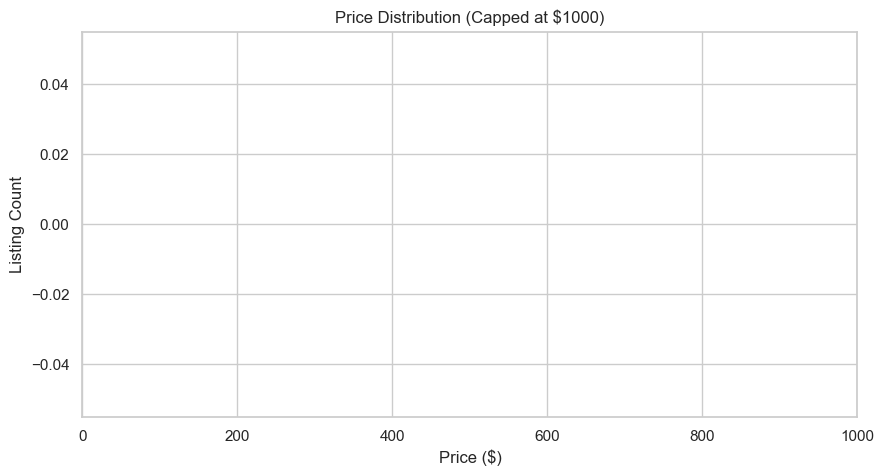

In [1]:
# 2. Data Loading & Initial Inspection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import warnings

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')  # Clean output

# -----------------------------------
# 📥 Load Dataset (robust to malformed rows)
# -----------------------------------
df = pd.read_csv(
    './Airbnb_Open_Data.csv',
    low_memory=False,
    quoting=csv.QUOTE_MINIMAL,
    quotechar='"',
    escapechar='\\',
    on_bad_lines='skip',
    encoding='utf-8'
)
print(f"✅ Dataset loaded — {df.shape[0]} rows × {df.shape[1]} columns\n")

# -----------------------------------
# 💵 Clean and Convert 'price' Column
# -----------------------------------
df['price'] = (
    df['price']
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df[df['price'].notnull()]  # Drop rows with invalid price

# -----------------------------------
# 🧾 Data Types and Structure
# -----------------------------------
print("📋 Column types and null counts:\n")
display(df.info())

# -----------------------------------
# 📊 Descriptive Statistics
# -----------------------------------
print("\n📊 Summary statistics (numeric columns):\n")
display(df.describe())

# -----------------------------------
# 🔍 Missing Value Analysis
# -----------------------------------
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\n🔍 Columns with missing values:\n")
display(missing)

# -----------------------------------
# 💵 Price Value Checks
# -----------------------------------
print(f"\nListings with price = $0: {(df['price'] == 0).sum()}")
print(f"Listings with price > $1000: {(df['price'] > 1000).sum()}")

# -----------------------------------
# 📈 Price Distribution Plot
# -----------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution (Capped at $1000)")
plt.xlabel("Price ($)")
plt.ylabel("Listing Count")
plt.xlim(0, 1000)
plt.show()


# 3. Preprocessing & Feature Engineering

In this section, we prepare the dataset for modeling by handling missing values, removing irrelevant or non-informative columns, and creating new quantitative features that may improve predictive performance. The goal is to ensure that the input data is clean, consistent, and suitable for use in machine learning algorithms, with a focus on keeping only numeric variables to simplify modeling and interpretability.


In [2]:
# 3. Preprocessing & Feature Engineering (Debug Version)

import pandas as pd
import numpy as np

# 📥 Load dataset
df = pd.read_csv('./Airbnb_Open_Data.csv', low_memory=False)
print(f"📄 Raw dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# ---------------------------------------
# 💵 Clean and Convert Price Column
# ---------------------------------------
print("\n🔍 First 10 raw price values:")
print(df['price'].head(10))

# Remove non-numeric characters from price like "$", ",", "USD"
df['price'] = (
    df['price']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .str.strip()
)

# Convert to numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Print summary before filtering
print("\n📊 Price column stats BEFORE filtering:")
print(df['price'].describe())
print(f"⛔ Price <= 0: {(df['price'] <= 0).sum()}")
print(f"⛔ Price > 5000: {(df['price'] > 5000).sum()}")
print(f"❓ Price NaNs: {df['price'].isna().sum()}")

# Filter out unrealistic price values
df = df[df['price'].notnull() & (df['price'] > 0) & (df['price'] < 5000)]
print(f"\n✅ Rows after price filtering: {df.shape[0]}")

# ---------------------------------------
# 🧹 Drop Irrelevant or Text Columns
# ---------------------------------------
columns_to_drop = [
    'id', 'name', 'host_id', 'host id', 'host_name', 'description',
    'license', 'neighbourhood_group', 'neighbourhood',
    'room_type', 'last_review', 'first_review', 'calendar_last_scraped'
]

# Confirm host_id is dropped
if 'host id' in df.columns:
    print("🚫 Dropping 'host id' (identifier column)")
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# ---------------------------------------
# 🛠 Feature Engineering
# ---------------------------------------

# reviews_per_month fill
if 'reviews_per_month' in df.columns:
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# host_days_active from host_since
if 'host_since' in df.columns:
    df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
    df['host_days_active'] = (pd.Timestamp.today() - df['host_since']).dt.days
    df['host_days_active'] = df['host_days_active'].fillna(df['host_days_active'].median())
    df.drop(columns=['host_since'], inplace=True)

# amenity_count from amenities
if 'amenities' in df.columns:
    df['amenity_count'] = df['amenities'].apply(lambda x: len(str(x).split(',')))
    df.drop(columns=['amenities'], inplace=True)

# ---------------------------------------
#  Keep Only Numeric Columns
# ---------------------------------------
df_numeric = df.select_dtypes(include=[np.number]).copy()

# Drop columns with >10% missing values
min_required = int(len(df_numeric) * 0.9)
df_numeric.dropna(axis=1, thresh=min_required, inplace=True)

# Fill remaining missing values
df_numeric.fillna(0, inplace=True)

# ---------------------------------------
# 🚫 Drop review rate number (collinearity / misleading impact)
# ---------------------------------------
if 'review rate number' in df_numeric.columns:
    print("🚫 Dropping 'review rate number' due to misleading effect on model.")
    df_numeric.drop(columns=['review rate number'], inplace=True)

# ---------------------------------------
# Split Features and Target
# ---------------------------------------
target = 'price'

if target not in df_numeric.columns:
    raise ValueError(" Target column 'price' is missing after cleaning!")

X = df_numeric.drop(columns=[target])
y = df_numeric[target]

print(f"\n📐 Cleaned feature matrix shape: {X.shape}")
print(f"🎯 Target variable shape: {y.shape}")

# ✅ Confirm we still have usable data
if len(X) == 0 or len(y) == 0:
    raise ValueError("❌ Dataset is empty after cleaning! Check filtering steps.")

# 💾 Save for reuse
X.to_csv('./features_X.csv', index=False)
y.to_csv('./target_y.csv', index=False)
print("\n💾 Saved: features_X.csv and target_y.csv")


📄 Raw dataset loaded: 102599 rows, 26 columns

🔍 First 10 raw price values:
0      $966 
1      $142 
2      $620 
3      $368 
4      $204 
5      $577 
6       $71 
7    $1,060 
8    $1,018 
9      $291 
Name: price, dtype: object

📊 Price column stats BEFORE filtering:
count    102352.000000
mean        625.293536
std         331.671614
min          50.000000
25%         340.000000
50%         624.000000
75%         913.000000
max        1200.000000
Name: price, dtype: float64
⛔ Price <= 0: 0
⛔ Price > 5000: 0
❓ Price NaNs: 247

✅ Rows after price filtering: 102352
🚫 Dropping 'host id' (identifier column)
🚫 Dropping 'review rate number' due to misleading effect on model.

📐 Cleaned feature matrix shape: (102352, 7)
🎯 Target variable shape: (102352,)

💾 Saved: features_X.csv and target_y.csv


# 4. Exploratory Data Analysis (EDA)

In this section, we perform exploratory analysis on the cleaned dataset to understand the relationships between key features and the target variable (`price`). We visualize distributions, correlations, and outliers to identify trends and potential data issues. These insights will help guide decisions about feature selection, transformations, and model strategy in the next steps.


✅ Dataset loaded for EDA
📐 Shape: (102352, 8)
🧠 Columns: ['lat', 'long', 'Construction year', 'minimum nights', 'number of reviews', 'calculated host listings count', 'availability 365', 'price']


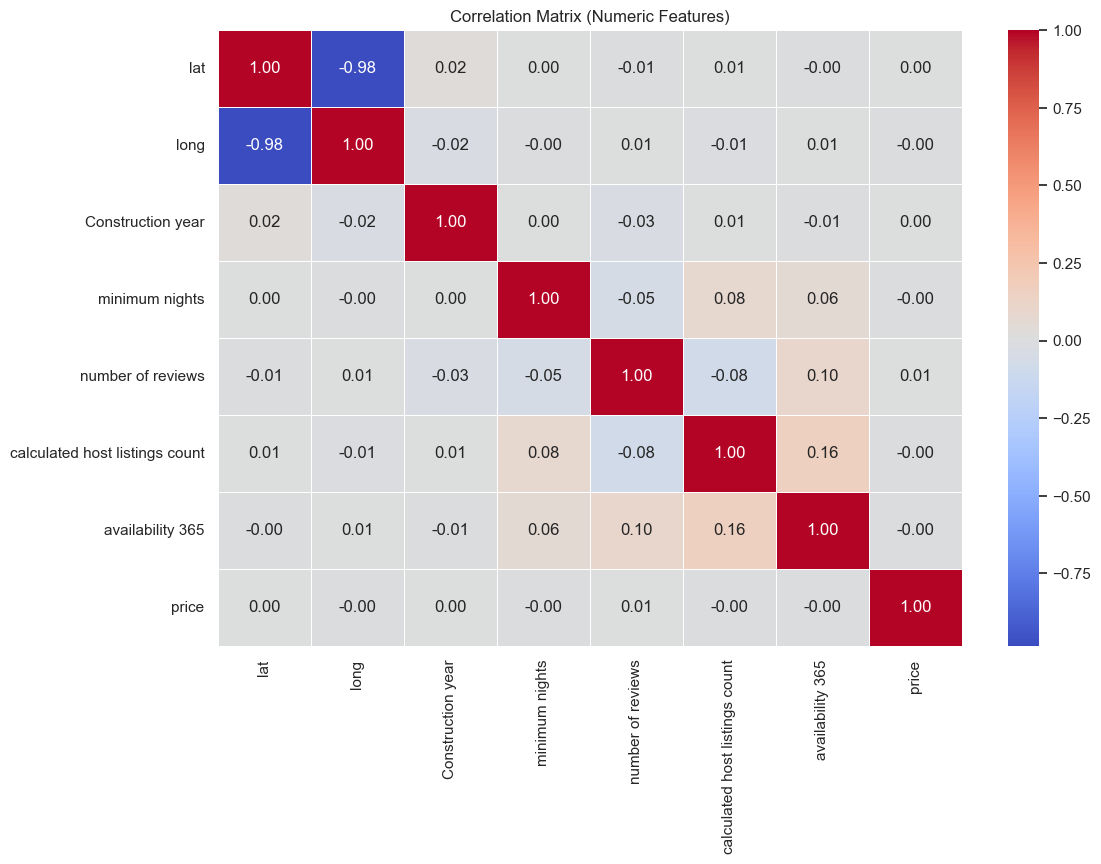


Top features correlated with price:

number of reviews                 0.005324
Construction year                 0.003249
lat                               0.001513
calculated host listings count   -0.000111
long                             -0.002193
availability 365                 -0.002720
minimum nights                   -0.003417
Name: price, dtype: float64


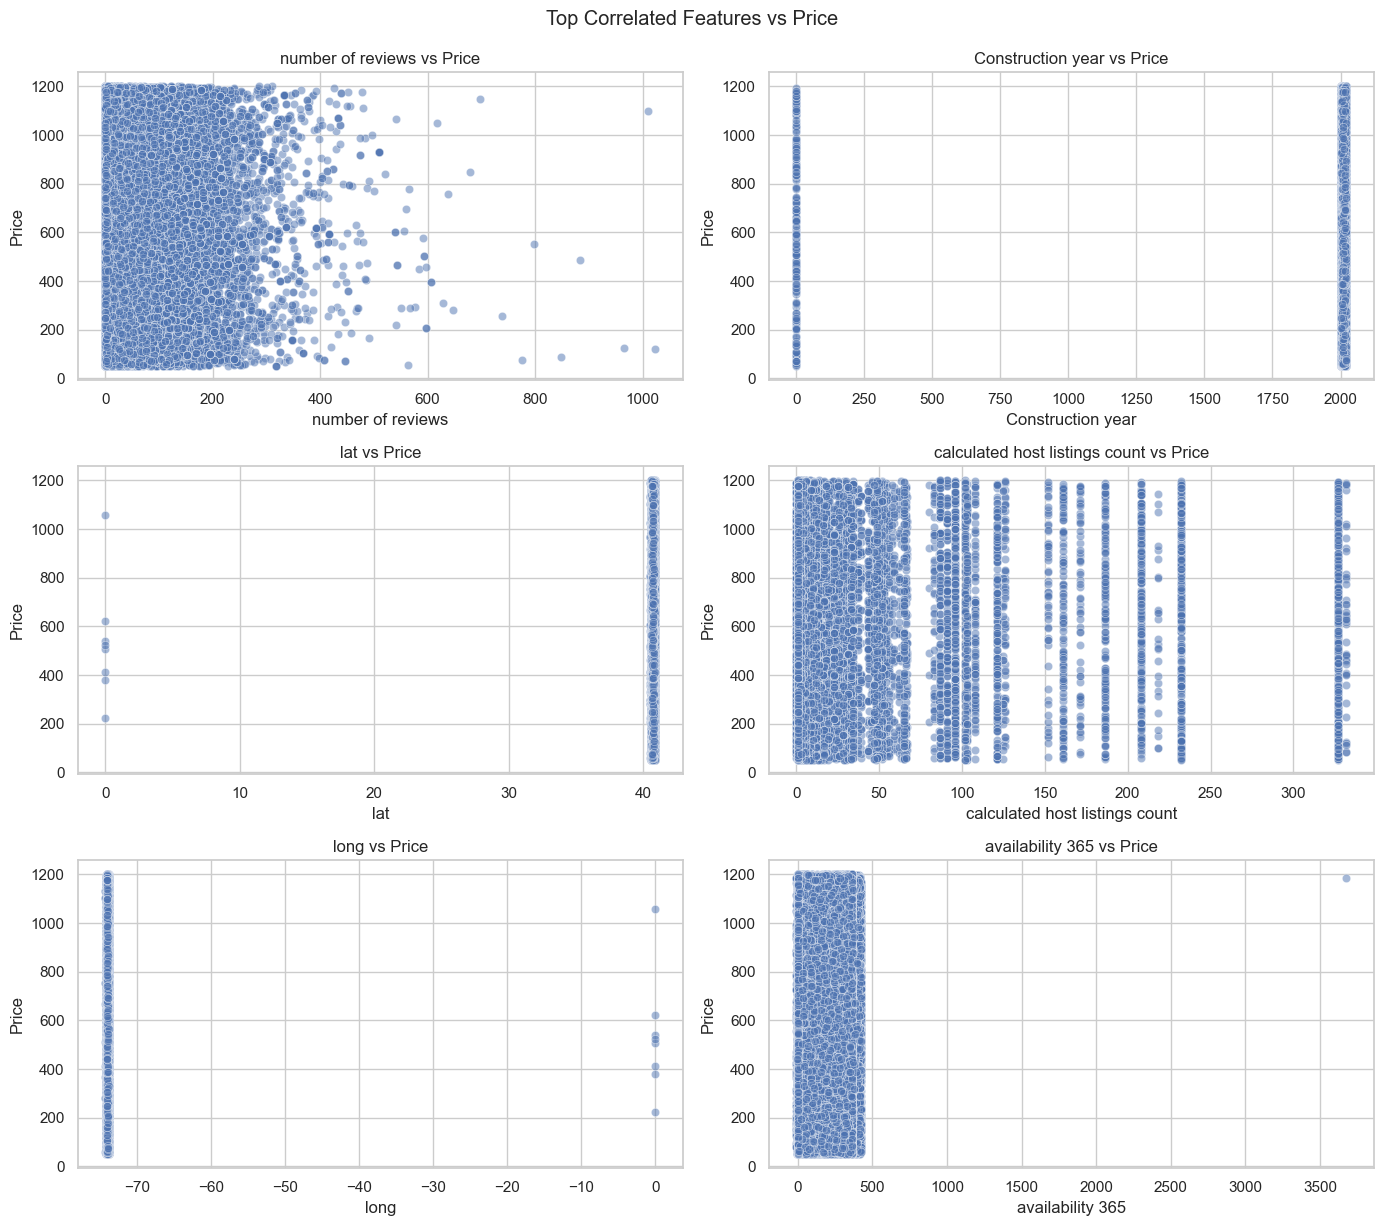

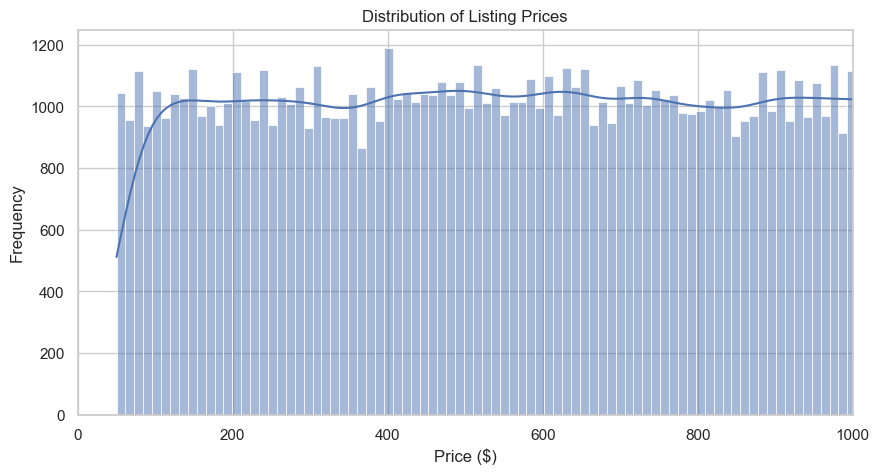

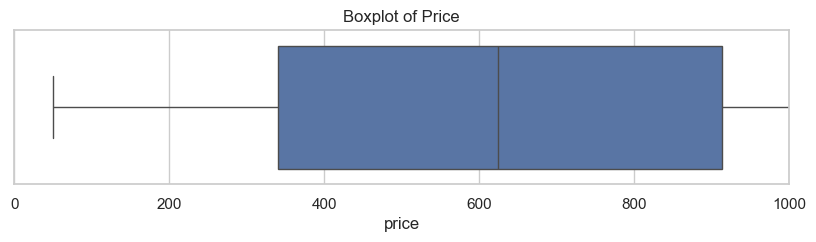

In [3]:
# 4. Exploratory Data Analysis (EDA)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔄 Load data
X = pd.read_csv('./features_X.csv')
y = pd.read_csv('./target_y.csv')

# 🔧 Ensure `y` is a Series
# When loading a CSV with a single column, pandas may interpret it as a DataFrame.
# We extract the 'price' column to work with it as a Series.
if 'price' in y.columns:
    y = y['price']

# ✅ Combine features and target into one dataframe
df_eda = X.copy()
df_eda['price'] = y

# -------------------------------
# Sanity check
# -------------------------------
print("✅ Dataset loaded for EDA")
print("📐 Shape:", df_eda.shape)
print("🧠 Columns:", list(df_eda.columns))

# -------------------------------
# 1. Correlation Matrix
# -------------------------------
corr = df_eda.corr(numeric_only=True)

if corr.shape[0] > 1:
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix (Numeric Features)")
    plt.show()
else:
    print("⚠️ Not enough numeric features to plot correlation heatmap.")

# -------------------------------
# 2. Top Correlations with Price
# -------------------------------
if 'price' in corr.columns:
    top_features = corr['price'].drop('price').sort_values(ascending=False).head(10)
    print("\nTop features correlated with price:\n")
    print(top_features)
else:
    print("⚠️ Could not compute correlations with price.")

# -------------------------------
# 3. Scatterplots for Top Features
# -------------------------------
top_vars = top_features.index.tolist() if 'top_features' in locals() else []

if top_vars:
    plt.figure(figsize=(14, 12))
    for i, col in enumerate(top_vars[:6]):
        plt.subplot(3, 2, i + 1)
        sns.scatterplot(x=df_eda[col], y=df_eda['price'], alpha=0.5)
        plt.title(f"{col} vs Price")
        plt.xlabel(col)
        plt.ylabel("Price")
        plt.tight_layout()
    plt.suptitle("Top Correlated Features vs Price", y=1.02)
    plt.show()
else:
    print("⚠️ No features found for scatterplots.")

# -------------------------------
# 4. Price Distribution
# -------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(df_eda['price'], bins=100, kde=True)
plt.title("Distribution of Listing Prices")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.xlim(0, 1000)
plt.show()

# -------------------------------
# 5. Boxplot of Price
# -------------------------------
plt.figure(figsize=(10, 2))
sns.boxplot(x=df_eda['price'])
plt.title("Boxplot of Price")
plt.xlim(0, 1000)
plt.show()

## 5. Model Building & Evaluation
In this section, we build and evaluate predictive models using the cleaned Airbnb dataset. The goal is to estimate listing prices using interpretable machine learning algorithms. We begin by splitting the data into training and testing sets, then train baseline models such as Linear Regression and Decision Tree Regressor. Performance is assessed using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). These insights will help us understand which features contribute most to price prediction and lay the groundwork for deeper explainability in the next section.

🧪 Train shape: (81881, 7), 🎯 (81881,)
🧾 Test shape: (20471, 7), 🎯 (20471,)

📊 Linear Regression Evaluation:
  MAE  = 287.03
  RMSE = 332.23

📊 Decision Tree Evaluation:
  MAE  = 286.75
  RMSE = 332.15


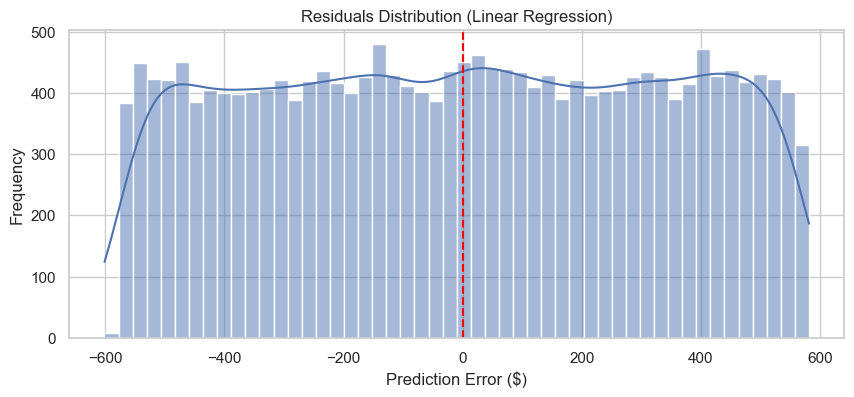

In [4]:
# 5. Model Building & Evaluation

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📥 Load Cleaned Data
# -------------------------------
X = pd.read_csv('./features_X.csv')
y = pd.read_csv('./target_y.csv')

# Ensure y is a Series (not DataFrame)
if 'price' in y.columns:
    y = y['price']

# 🚫 Confirm 'host_id' is not in features
if 'host_id' in X.columns:
    raise ValueError("❌ 'host_id' still present in feature matrix! It must be removed.")

# ⚠️ Warn if 'review_rate_number' exists for later review
if 'review_rate_number' in X.columns:
    print("⚠️ 'review_rate_number' is included — monitor for possible multicollinearity.")

# -------------------------------
# 📊 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"🧪 Train shape: {X_train.shape}, 🎯 {y_train.shape}")
print(f"🧾 Test shape: {X_test.shape}, 🎯 {y_test.shape}")

# -------------------------------
# 🔧 Train Linear Regression Model
# -------------------------------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# -------------------------------
# 🌲 Train Decision Tree Model
# -------------------------------
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

# -------------------------------
# 📈 Evaluation Function
# -------------------------------
def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n📊 {model_name} Evaluation:")
    print(f"  MAE  = {mae:.2f}")
    print(f"  RMSE = {rmse:.2f}")

# Evaluate both models
evaluate_model(y_test, y_pred_lr, model_name="Linear Regression")
evaluate_model(y_test, y_pred_tree, model_name="Decision Tree")

# -------------------------------
# 📉 Residual Plot (Linear Regression)
# -------------------------------
residuals = y_test - y_pred_lr
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution (Linear Regression)")
plt.xlabel("Prediction Error ($)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()


## 6. Model Interpretation & Explainability

In this section, we interpret the trained models to understand how different features influence Airbnb price predictions. We prioritize explainability to ensure the model's decisions are transparent and trustworthy. For this, we analyze the coefficients of the Linear Regression model and the feature importances from the Decision Tree model. These insights help identify which factors most significantly affect listing prices.


🔍 Top 10 Positive Coefficients (Linear Regression):
number of reviews                  0.057930
calculated host listings count     0.014554
Construction year                  0.010117
availability 365                  -0.003953
minimum nights                    -0.017727
long                             -14.447756
lat                              -25.042602
dtype: float64

🔍 Top 10 Negative Coefficients (Linear Regression):
lat                              -25.042602
long                             -14.447756
minimum nights                    -0.017727
availability 365                  -0.003953
Construction year                  0.010117
calculated host listings count     0.014554
number of reviews                  0.057930
dtype: float64


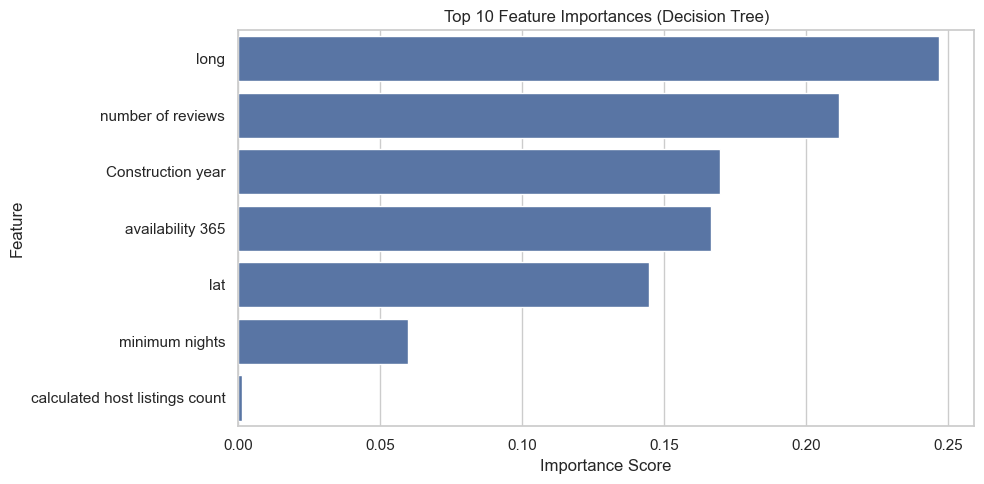

In [5]:
# 6. Model Interpretation & Explainability

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 🌳 Decision Tree Feature Importances
# -------------------------------
importances = pd.Series(tree_model.feature_importances_, index=X.columns)

# Filter out 'host_id' if it somehow exists
if 'host_id' in importances.index:
    print("🚫 Removing 'host_id' from feature importances")
    importances = importances.drop('host_id')

# -------------------------------
# 📊 Linear Regression Coefficients
# -------------------------------
coefficients = pd.Series(lr_model.coef_, index=X.columns)

# Filter out 'host_id' if it somehow exists
if 'host_id' in coefficients.index:
    print("🚫 Removing 'host_id' from linear regression coefficients")
    coefficients = coefficients.drop('host_id')

# Display top 10 positive and negative coefficients
top_positive = coefficients.sort_values(ascending=False).head(10)
top_negative = coefficients.sort_values().head(10)

print("🔍 Top 10 Positive Coefficients (Linear Regression):")
print(top_positive)

print("\n🔍 Top 10 Negative Coefficients (Linear Regression):")
print(top_negative)

# -------------------------------
# 🌳 Decision Tree Feature Importances Plot
# -------------------------------
top_importances = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_importances.values, y=top_importances.index)
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Section 7: Model Explainability (Advanced)

Purpose of This Section:

In this section, we apply advanced model explainability tools to better understand how the features influence predictions on an individual and global level. This step is essential for ensuring the model remains interpretable and trustworthy, particularly when used in real-world pricing scenarios.

We’ll use tools like:

    SHAP (SHapley Additive exPlanations) for feature contribution insights

    Partial Dependence Plots (PDPs) to visualize marginal effects

    Possibly LIME if needed for local explanations

📈 Initializing SHAP explainer for Linear Regression...


ExactExplainer explainer: 102353it [04:22, 390.41it/s]                                                


🌲 Initializing SHAP explainer for Decision Tree...


ExactExplainer explainer: 102353it [03:55, 416.12it/s]                                                



📊 SHAP Summary Plot: Linear Regression


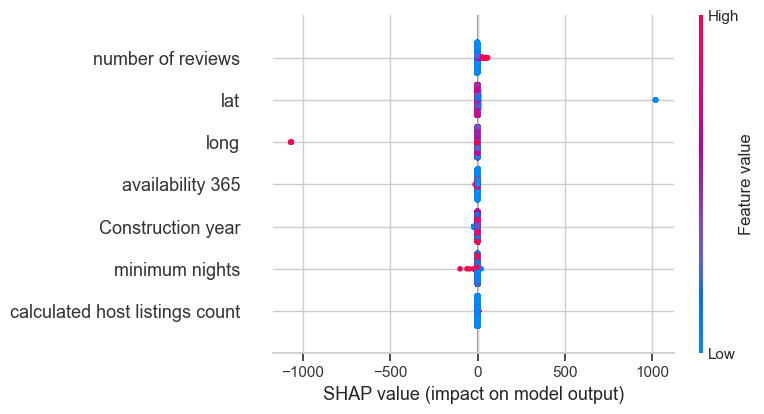


📊 SHAP Summary Plot: Decision Tree


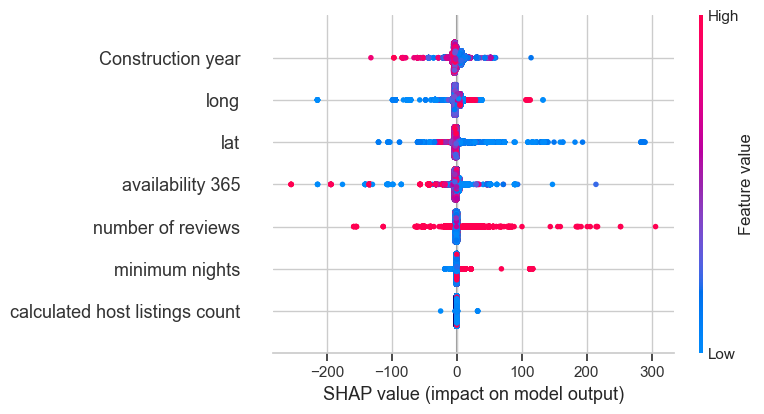


🔍 SHAP Waterfall Plot: Sample 0 — Linear Regression


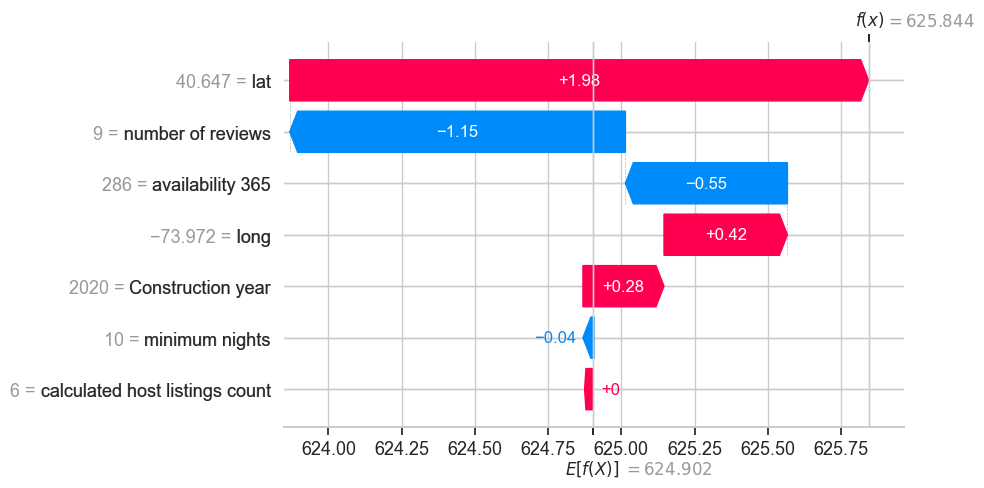


🔍 SHAP Waterfall Plot: Sample 0 — Decision Tree


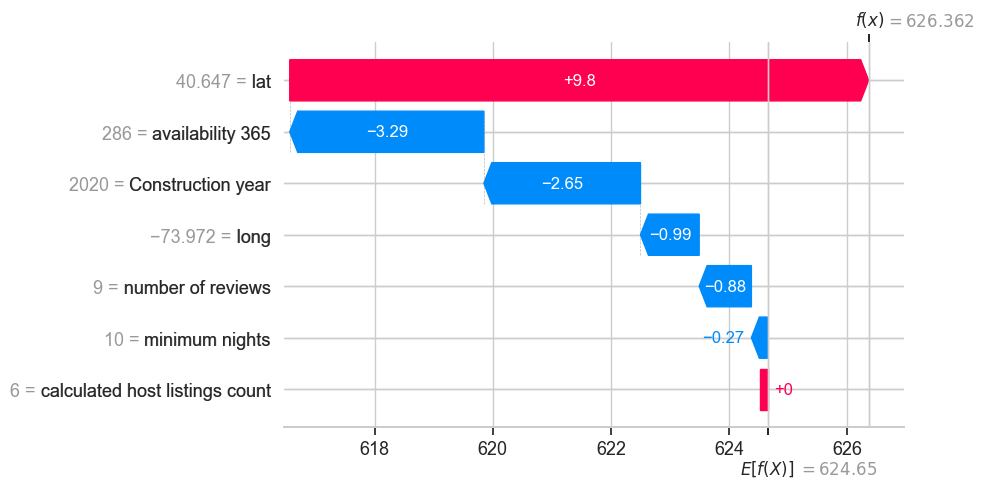


📈 PDP for features: ['lat', 'long', 'minimum nights', 'availability 365']


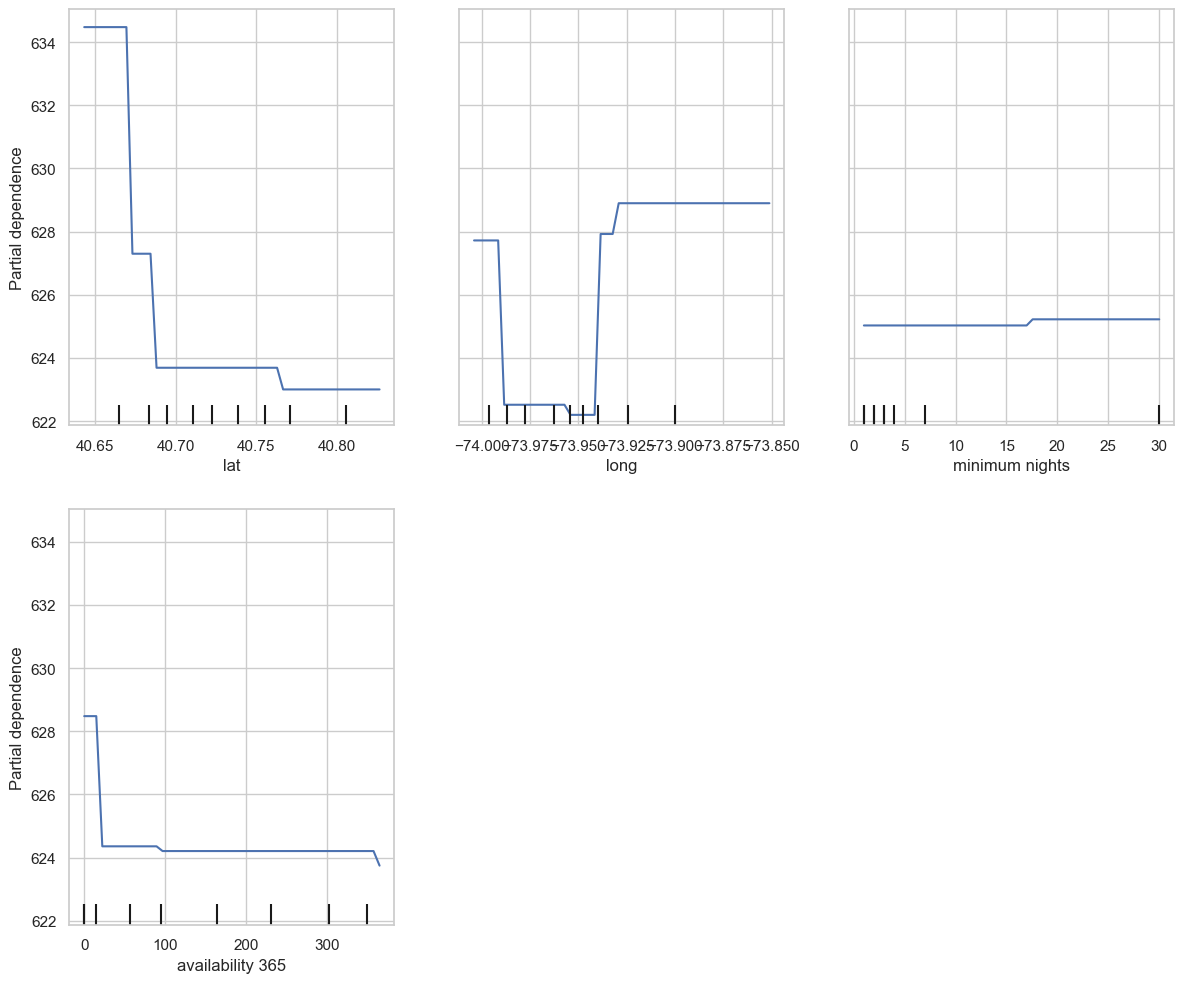

In [6]:
# 7. Model Explainability (Advanced)

import shap
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------
# 📦 SHAP Explainability
# -----------------------------------

print("📈 Initializing SHAP explainer for Linear Regression...")
lr_explainer = shap.Explainer(lr_model.predict, X)
lr_shap_values = lr_explainer(X)

print("🌲 Initializing SHAP explainer for Decision Tree...")
tree_explainer = shap.Explainer(tree_model.predict, X)
tree_shap_values = tree_explainer(X)

# 📊 SHAP Summary Plot — Linear Regression
print("\n📊 SHAP Summary Plot: Linear Regression")
shap.summary_plot(lr_shap_values, X)

# 📊 SHAP Summary Plot — Decision Tree
print("\n📊 SHAP Summary Plot: Decision Tree")
shap.summary_plot(tree_shap_values, X)

# 🔍 SHAP Waterfall for One Sample (local explanation)
sample_idx = 0
print(f"\n🔍 SHAP Waterfall Plot: Sample {sample_idx} — Linear Regression")
shap.plots.waterfall(lr_shap_values[sample_idx], max_display=10)

print(f"\n🔍 SHAP Waterfall Plot: Sample {sample_idx} — Decision Tree")
shap.plots.waterfall(tree_shap_values[sample_idx], max_display=10)

# -----------------------------------
# 📈 Partial Dependence Plots (PDP)
# -----------------------------------
features_to_plot = ['lat', 'long', 'minimum nights', 'availability 365']

print(f"\n📈 PDP for features: {features_to_plot}")
fig, ax = plt.subplots(figsize=(12, 10))
PartialDependenceDisplay.from_estimator(
    tree_model,
    X,
    features=features_to_plot,
    grid_resolution=50,
    ax=ax
)
plt.tight_layout()
plt.show()


## Project Summary

This notebook outlines a complete pipeline for predicting Airbnb listing prices with an emphasis on interpretability.

### Key Steps:

- **Data Preparation:** Cleaned and filtered the dataset, engineered relevant features, and removed identifiers and misleading variables.
- **Modeling:** Trained and evaluated Linear Regression and Decision Tree models using MAE and RMSE metrics.
- **Explainability:** Interpreted models using feature importances, SHAP values, and Partial Dependence Plots.

### Conclusion:

The workflow balances predictive performance with transparency, making it suitable for real-world pricing scenarios where interpretability matters.
